In [1]:
# FInds out why the first part work but the second part doesnt?!!!!

from torchviz import make_dot
import torch
from src.models.question_rnn import QuestionRNN
from src.models.selector import Selector
from src.models.neural_programmer import NeuralProgrammer

from bin.train import scalar_loss

In [2]:
input_question = [1, 2, 3, 4, 5, 6, 0, 0, 0, 0]
input_question_numbers = []
left_word_indices = []
table = [[1., 2.], [3., 4.], [5., 6.]]
table = torch.tensor(table)

np = NeuralProgrammer(256, 10, 9, 2, 4)
scalar_answer, lookup_answer = np('train', input_question, input_question_numbers, left_word_indices, table)
print(scalar_answer)

tensor(1.0326, grad_fn=<AddBackward0>)


In [3]:
scalar_answer.backward()

In [4]:
list(np.parameters())[0].grad

tensor([[ 3.3303e-03,  1.0166e-03, -5.5245e-04,  ...,  3.0520e-03,
         -1.4197e-03,  1.9419e-03],
        [-2.7939e-07, -3.6826e-08, -5.0224e-08,  ..., -3.1234e-07,
         -5.8820e-07, -2.2731e-07],
        [-2.2112e-06, -4.1765e-07, -2.7718e-07,  ..., -1.1405e-06,
         -1.8786e-07,  5.3471e-07],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

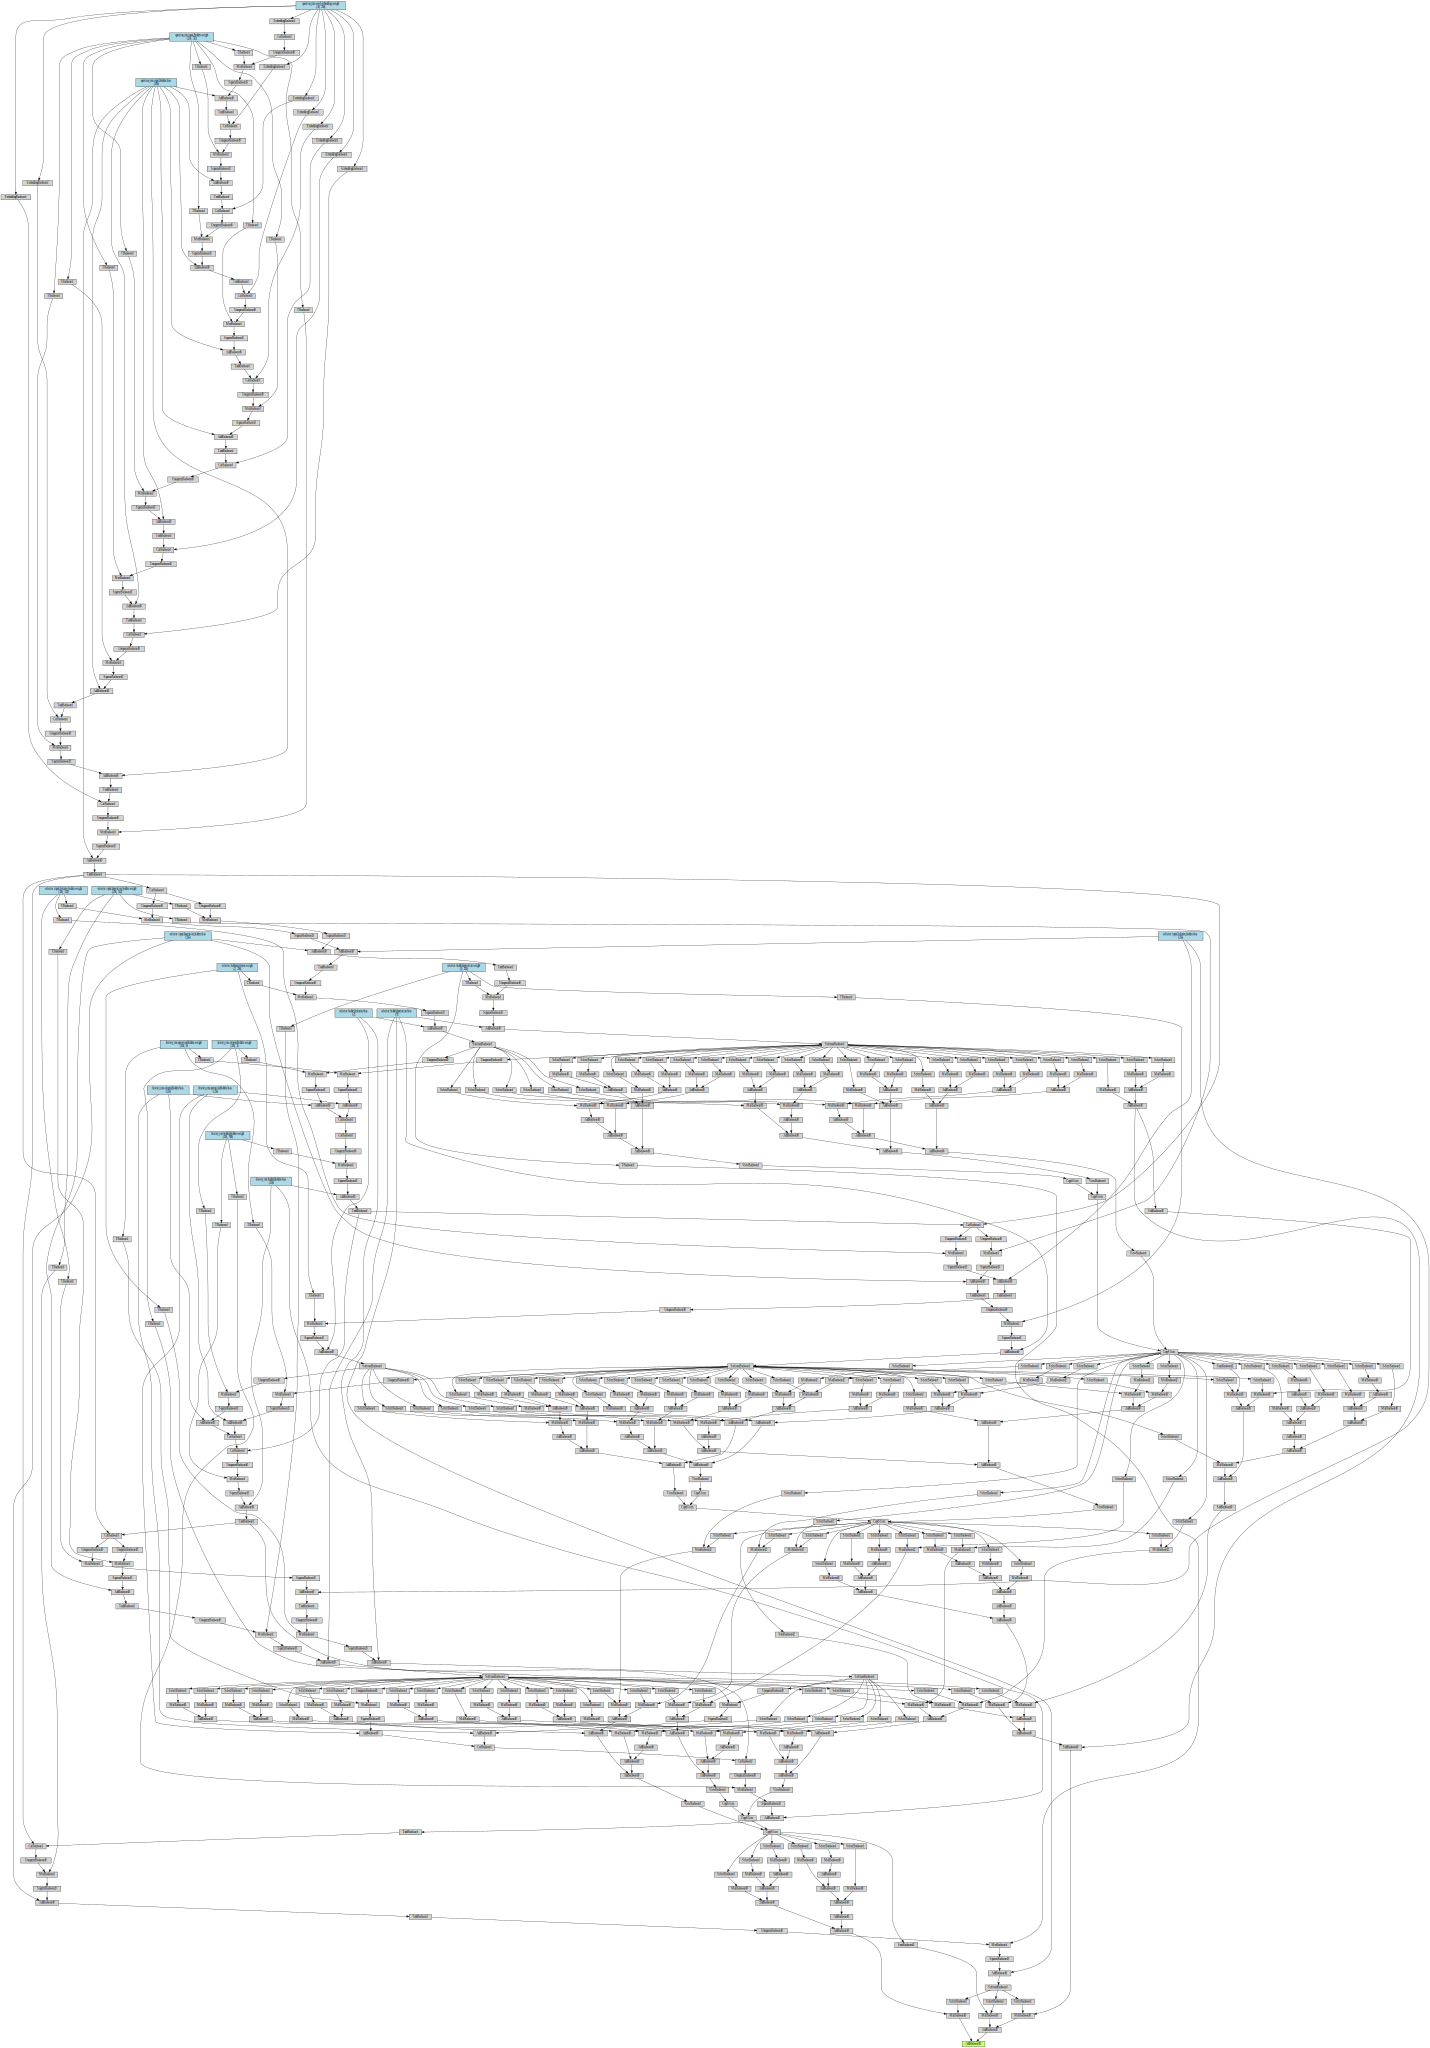

In [5]:
make_dot(scalar_answer, params=dict(np.named_parameters()))

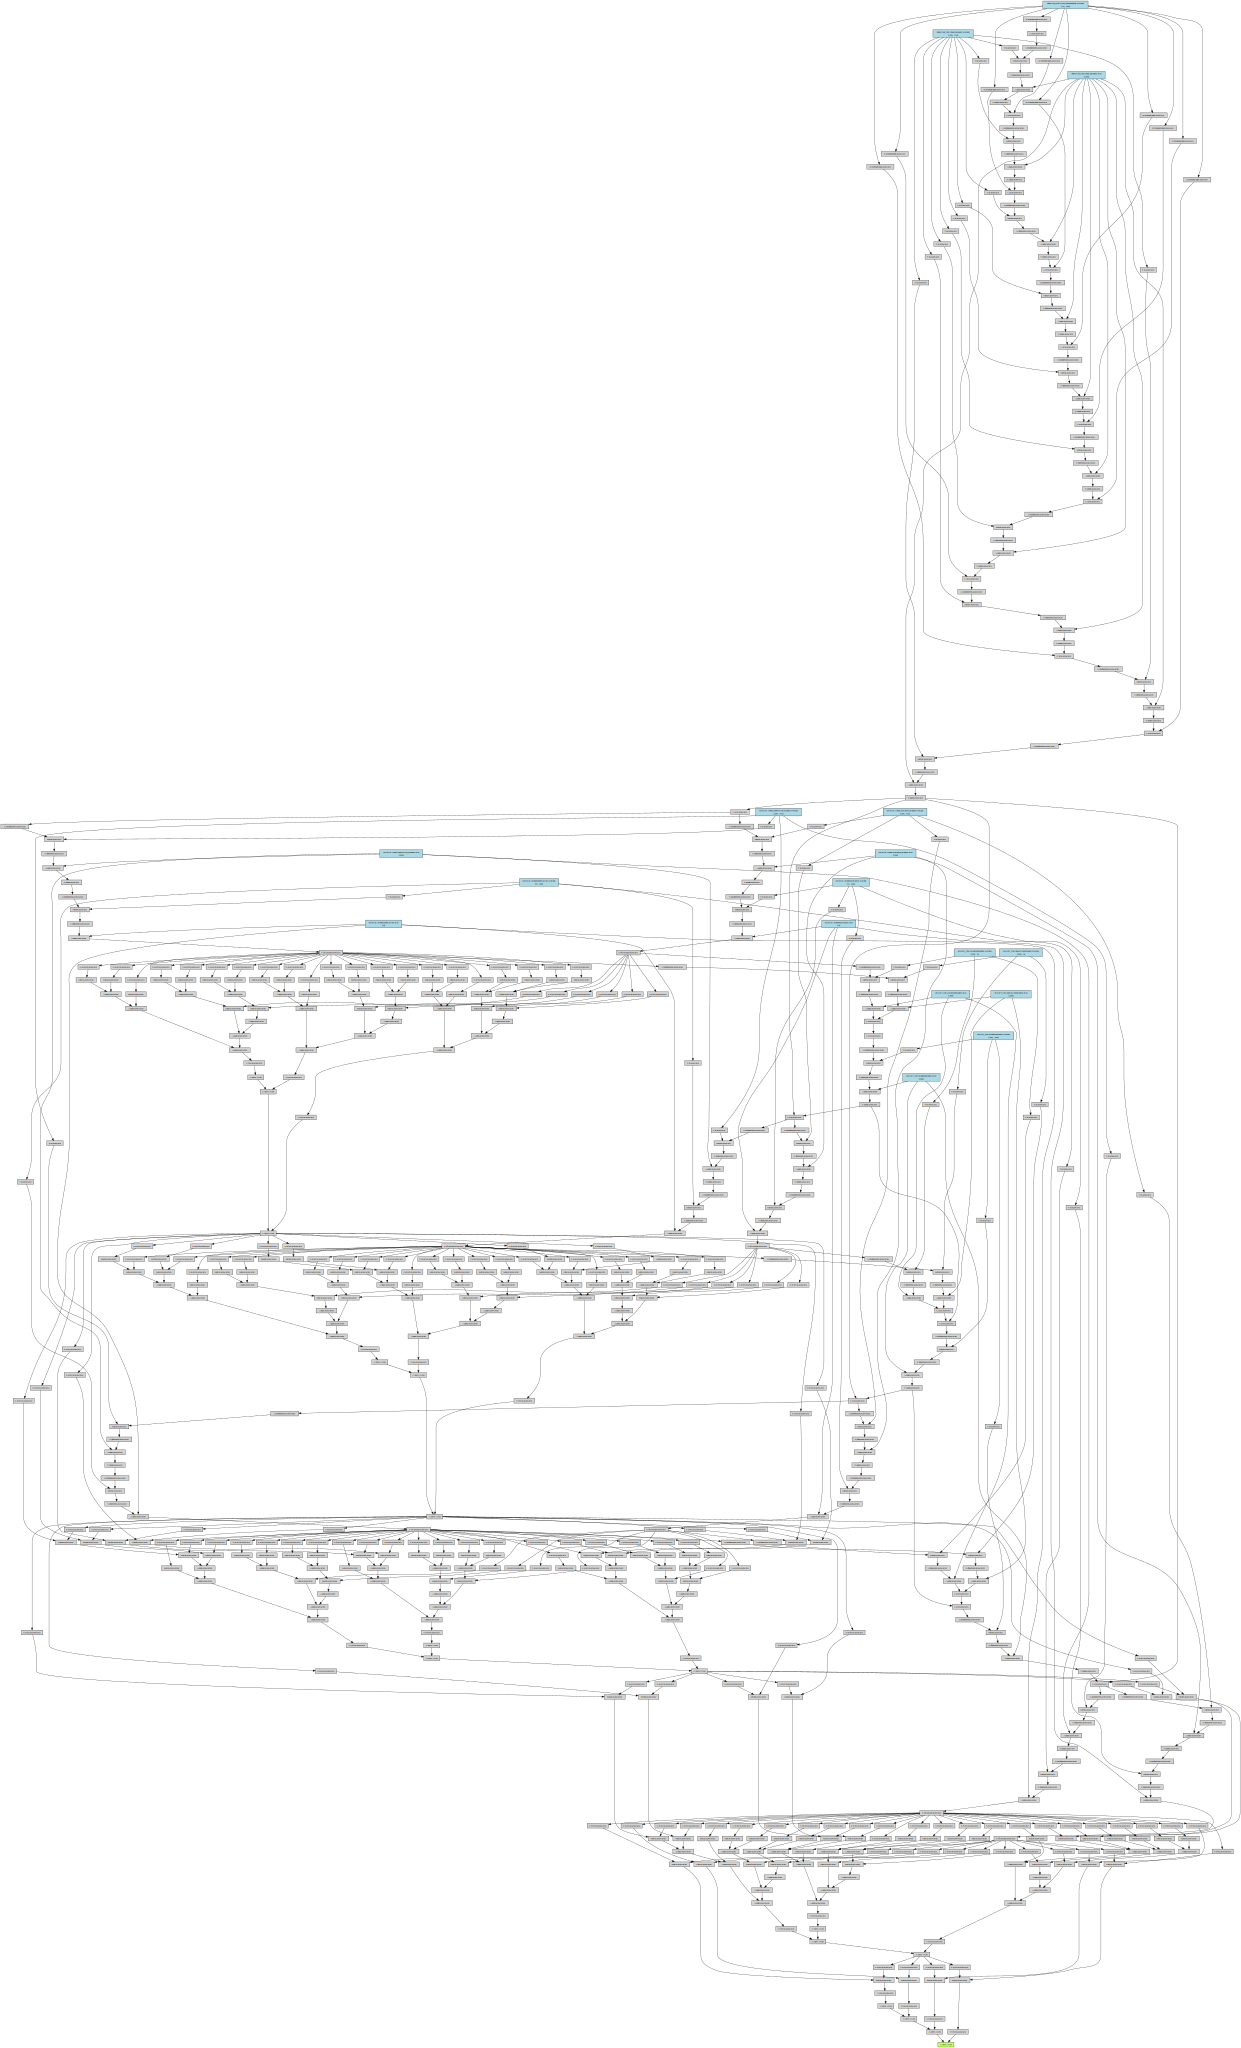

In [6]:
make_dot(lookup_answer, params=dict(np.named_parameters()))

In [20]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from src.models.question_rnn import QuestionRNN
from src.models.selector import Selector
from src.models.history_rnn import HistoryRNN
from src.models.operations import calc_scalar_answer, calc_lookup_answer, calc_row_select


class NeuralProgrammer(nn.Module):
    def __init__(self, hidden_size: int, vocab_size: int,
                 num_of_operations: int, num_of_columns: int, num_time_steps: int):
        super(NeuralProgrammer, self).__init__()
        self.hidden_size = hidden_size
        self.num_time_steps = num_time_steps

        self.question_rnn = QuestionRNN(hidden_size, vocab_size)
        self.selector = Selector(hidden_size, num_of_operations, num_of_columns)
        self.history_rnn = HistoryRNN(hidden_size, num_of_operations, num_of_columns)

        self.U = nn.Embedding(2, hidden_size)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, mode: str, input_question: [float], input_question_numbers: [float], left_word_indices: [float],
                table: torch.Tensor):
        # initializing the values at t = 0
        history_states = [torch.zeros(self.hidden_size)]
        scalar_answers = [torch.tensor(0.)]
        lookup_answers = [torch.zeros(table.size(0), table.size(1))]
        row_selects = [torch.ones(table.size(0))]
        z_matrix = torch.zeros(len(input_question_numbers), self.hidden_size)

        input_question_numbers = torch.tensor(input_question_numbers)
        left_word_indices = torch.tensor(left_word_indices)

        # Encoding the input question using the QuestionRNN module.
        encoded_question = self.question_rnn(input_question)
        question_hidden_states = self.question_rnn.hidden_states

        for i in range(len(input_question_numbers)):
            z_matrix[i] = question_hidden_states[int(left_word_indices[i])]

        for t in range(1, self.num_time_steps + 1):
            # Preparing the useful values
            history_state_past1 = history_states[-1]

            scalar_output_past1 = scalar_answers[-1]
            scalar_output_past3 = scalar_answers[max(0, len(scalar_answers) - 3)]

            row_select_past1 = row_selects[-1]
            row_select_past2 = row_selects[max(0, len(row_selects) - 2)]

            # Selecting the appropriate op and col using the Selector module.
            alpha_op, alpha_col = self.selector(encoded_question, history_state_past1)

            # Calculating row_select
            row_select = torch.zeros(table.size(0))
            if len(input_question_numbers) != 0:
                beta_lesser = self.softmax(z_matrix.mm(self.U(torch.tensor(0)).view(256, 1)))
                l_pivot = sum([beta_lesser[i] * input_question_numbers[i] for i in range(len(input_question_numbers))])
                beta_greater = self.softmax(z_matrix.mm(self.U(torch.tensor(1)).view(256, 1)))
                g_pivot = sum([beta_greater[i] * input_question_numbers[i] for i in range(len(input_question_numbers))])
            else:
                l_pivot = torch.tensor(0.)
                g_pivot = torch.tensor(0.)

            for i in range(table.size(0)):
                row_select[i] = calc_row_select(i, row_select_past1, row_select_past2, table, l_pivot, g_pivot,
                                                alpha_op, alpha_col)
            row_selects.append(row_select)

            # Calculating the scalar answer and lookup answer
            scalar_answer = calc_scalar_answer(row_select_past1, scalar_output_past3, scalar_output_past1,
                                               table, alpha_op)
            scalar_answers.append(scalar_answer)

            # TODO needs to check if it is okay to do this... If this will break a graph
            lookup_answer = torch.zeros(table.size(0), table.size(1))
            for i in range(table.size(0)):
                for j in range(table.size(1)):
                    lookup_answer[i][j] = calc_lookup_answer(i, j, row_select, alpha_col, alpha_op)
            lookup_answers.append(lookup_answer)

            history_state = self.history_rnn(alpha_op, alpha_col, history_state_past1)
            history_states.append(history_state)

        if mode == 'train':
            return scalar_answers[-1], lookup_answers[-1]
        elif mode == 'eval':
            if torch.all(torch.eq(lookup_answers[-1], lookup_answers[-2])):
                print('predicting scalar answer')
                return scalar_answers[-1], True
            else:
                print('predicting lookup answer')
                return lookup_answers[-1], False


def lookup_loss(guess: torch.Tensor, answer: torch.Tensor):
    assert guess.size() == answer.size()
    guess = Variable(guess, requires_grad=True)
    answer = Variable(answer)

    return (-1 / (torch.tensor(answer.size(0), dtype=torch.float)) * (
        torch.tensor(answer.size(1), dtype=torch.float))) * sum(
        [
            answer[i][j] * torch.log(guess[i][j] + torch.tensor(0.00000001)) +
            (torch.tensor(1.) - answer[i][j]) * torch.log(torch.tensor(1.) - guess[i][j])
            for j in range(answer.size(1)) for i in range(answer.size(0))
        ]
    )
            
            
def test_backward():
    input_question = [1, 2, 3, 4, 5, 6, 0, 0, 0, 0]
    input_question_numbers = [1.]
    left_word_indices = [2.]
    table = [[1.], [3.], [5.]]
    table = torch.tensor(table)

    np = NeuralProgrammer(256, 10, 9, 1, 4)
    scalar_answer, lookup_answer = np('train', input_question, input_question_numbers, left_word_indices, table)
    
    
#     print(scalar_answer)
    loss_fn = torch.nn.MSELoss()
    loss = scalar_loss(scalar_answer, torch.tensor(1.), 10.)
#     print(loss)
    loss.backward()
    print(list(np.parameters())[0].grad)
    print(list(np.parameters())[0].grad)
    print(list(np.parameters())[0].grad)
    
    


if __name__ == '__main__':
    test_backward()


tensor([[-4.4488e-04, -9.9304e-04, -5.9062e-04,  ..., -1.8536e-04,
         -1.3756e-04, -1.0177e-03],
        [ 8.1931e-08, -1.8846e-08, -6.2906e-08,  ..., -4.3796e-08,
         -4.3801e-08,  9.0284e-08],
        [-2.7619e-08, -1.5313e-08,  4.1859e-08,  ..., -3.0115e-08,
          1.7603e-07, -7.6564e-09],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
tensor([[-4.4488e-04, -9.9304e-04, -5.9062e-04,  ..., -1.8536e-04,
         -1.3756e-04, -1.0177e-03],
        [ 8.1931e-08, -1.8846e-08, -6.2906e-08,  ..., -4.3796e-08,
         -4.3801e-08,  9.0284e-08],
        [-2.7619e-08, -1.5313e-08,  4.1859e-08,  ..., -3.0115e-08,
          1.7603e-07, -7.6564e-09],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00

In [19]:
import json

import torch
from torch.autograd import Variable

from src.models.neural_programmer import NeuralProgrammer
from src.models.operations import OPERATIONS
from src.utils import is_number


def preprocess_data(question_dicts):
    preprocessed_questions = []
    all_question_numbers = []
    all_left_word_indices = []

    vocab = dict()

    for question_dict in question_dicts:
        question_numbers = []
        left_word_indices = []
        question = question_dict['question']
        question = question.split()
        for i in range(len(question)):
            if is_number(question[i]):
                # Assume that number will never occurs at the first place.
                question_numbers.append(int(question[i]))
                question[i] = 'NUM'
                left_word_indices.append(i - 1)

        all_question_numbers.append(question_numbers)
        all_left_word_indices.append(left_word_indices)

        preprocessed_question = []
        for token in question:
            if token not in vocab:
                vocab[token] = len(vocab)
            preprocessed_question.append(vocab[token])
        preprocessed_questions.append(preprocessed_question)

    return vocab, preprocessed_questions, all_question_numbers, all_left_word_indices


# TODO debug if something went wrong here with the loss function that causes the failure of backward!!!
def scalar_loss(guess, answer, huber):

    a = abs(guess - answer)
    if a <= huber:
        return 0.5 * pow(a, 2)
    else:
        return huber * a - 0.5 * pow(huber, 2)


def lookup_loss(guess: torch.Tensor, answer: torch.Tensor):
    assert guess.size() == answer.size()
    guess = Variable(guess, requires_grad=True)
    answer = Variable(answer)

    print([answer[i] * torch.log(guess[i]) +
           (torch.log(Variable(torch.tensor(1.))) - answer[i]) * torch.log(Variable(torch.tensor(1.))) - guess[i]
           for i in range(answer.size(0))])

    if answer.dim() == 1:
        return (-1 / torch.tensor(answer.size(0), dtype=torch.float)) * sum(
            [answer[i] * torch.log(guess[i]) +
             (torch.log(Variable(torch.tensor(1.))) - answer[i]) * torch.log(Variable(torch.tensor(1.))) - guess[i]
             for i in range(answer.size(0))]
        )


def loss_fn(scalar_guess, lookup_guess, answer, is_scalar):
    return scalar_loss(scalar_guess, answer, 10.) if is_scalar else lookup_loss(lookup_guess, answer)


def main():
    # TODO implement a mini-batch technique for training
    # file_name = '../../data/single_column_dataset_1000000.txt'
    file_name = './data/single_column_dataset.txt'
    print('Loading dataset...')
    with open(file_name, 'r') as f:
        question_dicts = json.load(f)

    print('Pre-processing the questions...')
    vocab, preprocessed_questions, all_question_numbers, all_left_word_indices = \
        preprocess_data(question_dicts)

    model = NeuralProgrammer(256, len(vocab), len(OPERATIONS), 1, 4)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    print('Starting to train...')
    for epoch in range(1000):
        total_loss = 0.0
        for i in range(len(preprocessed_questions)):
            preprocessed_question = preprocessed_questions[i]
            question_numbers = all_question_numbers[i]
            left_word_indices = all_left_word_indices[i]
            answer = torch.tensor(question_dicts[i]['answer'])
            is_scalar = torch.tensor(question_dicts[i]['answer_type'])
            table = torch.tensor(question_dicts[i]['table']).t()

            scalar_guess, lookup_guess = model('train', preprocessed_question, question_numbers, left_word_indices, table)
            
            loss = scalar_loss(scalar_guess, answer, 10.)
            
            optimizer.zero_grad()
            loss.backward()
            print(list(model.parameters())[0].grad)
            return
            optimizer.step()
            
            
            total_loss += loss

            
        print(('avg loss at epoch %d: ' % epoch), total_loss / len(preprocessed_question))


if __name__ == '__main__':
    main()


Loading dataset...
Pre-processing the questions...
Starting to train...
tensor([[ 1.1911e-02,  5.6157e-03, -1.3294e-02,  1.2258e-02,  3.2571e-02,
          1.4731e-02, -7.9845e-03,  1.2231e-02,  1.3635e-02, -2.1765e-02,
          3.3470e-02, -8.8025e-04, -1.2240e-02,  2.9102e-03,  1.1475e-02,
          4.5197e-03, -5.1810e-03,  2.4331e-03, -7.0380e-03,  3.2847e-02,
          3.9063e-03, -1.6533e-02, -1.1531e-02, -5.4126e-03, -3.1440e-02,
         -1.3134e-03,  2.3852e-02,  7.0623e-03,  6.6561e-03,  3.3360e-02,
         -1.6486e-02,  2.6169e-02,  1.9969e-03, -8.0651e-03, -6.1145e-03,
          8.3989e-03,  8.3867e-03,  3.1864e-02,  9.2451e-03, -3.2620e-02,
         -2.5305e-02,  1.2156e-02, -6.3900e-02,  2.3200e-02,  1.0300e-02,
         -1.0848e-02, -2.1454e-02, -1.3328e-02, -8.5043e-03, -1.7132e-02,
          4.7022e-02,  2.9734e-03,  1.7409e-02,  4.0174e-02, -1.1592e-02,
         -1.7256e-04, -1.0835e-02,  1.7400e-02, -4.8019e-03, -2.1064e-03,
          6.3126e-03, -1.6433e-02, -2.82